# SAM3 Prompt Strategy Comparison

This notebook compares different text prompt strategies for SAM3 boundary generation.

We test 4 levels of prompt specificity:
1. **L1_Baseline**: Simple, generic terms (e.g., "fence", "pole")
2. **L2_Descriptive**: More descriptive (e.g., "metal fence", "street pole")
3. **L3_Physical**: Physical attributes emphasized (e.g., "thin vertical metal fence barrier")
4. **L4_Specific**: Context and location details (e.g., "street fence barrier along road edge")

The goal is to determine which level of prompt specificity produces the best boundary detection for thin objects in urban scenes.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch

from transformers import Sam3Processor, Sam3Model

# Import prompt strategies
from generate_sam3_masks import (
    load_sam3_model,
    generate_boundary_for_crop,
    PROMPT_STRATEGIES,
    PROMPTS_L1_BASELINE,
    PROMPTS_L2_DESCRIPTIVE,
    PROMPTS_L3_PHYSICAL,
    PROMPTS_L4_SPECIFIC
)

## Configuration

In [2]:
# Path to your Cityscapes dataset
CITYSCAPES_ROOT = Path("../data/cityscapes")

# Select a sample image (change this to test different images)
# Good images to test: those with many thin objects (poles, signs, fences, people)
SAMPLE_IMAGE = CITYSCAPES_ROOT / "leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Verify image exists
if not SAMPLE_IMAGE.exists():
    print(f"⚠️ Sample image not found: {SAMPLE_IMAGE}")
    print("Please update SAMPLE_IMAGE path to a valid Cityscapes image")
else:
    print(f"✓ Sample image found: {SAMPLE_IMAGE.name}")

Using device: cuda
✓ Sample image found: frankfurt_000000_000294_leftImg8bit.png


## Load SAM3 Model

In [3]:
model, processor = load_sam3_model(DEVICE)

Loading SAM3 model on cuda...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

SAM3 model loaded successfully


## Load Sample Image

Image size: (2048, 1024)


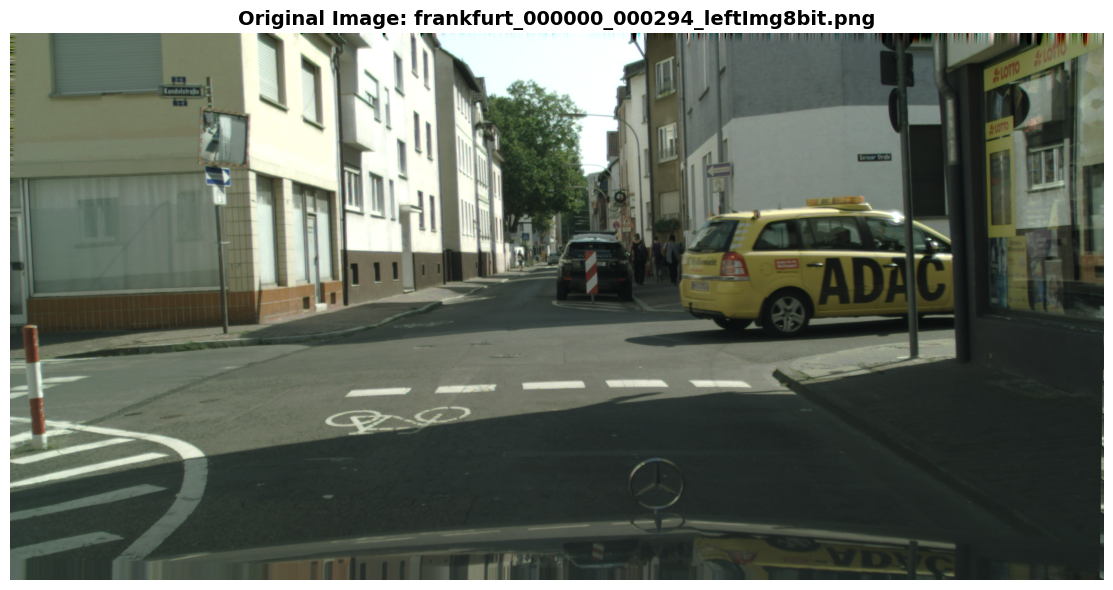

In [4]:
image = Image.open(SAMPLE_IMAGE).convert("RGB")
print(f"Image size: {image.size}")

# Display the original image
plt.figure(figsize=(16, 6))
plt.imshow(image)
plt.title(f"Original Image: {SAMPLE_IMAGE.name}", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Show All Prompt Strategies

Let's see what prompts we're testing for each level.

In [5]:
# Cityscapes class names for reference
CLASS_NAMES = {
    4: "fence",
    5: "pole", 
    6: "traffic light",
    7: "traffic sign",
    11: "person",
    12: "rider",
    17: "motorcycle",
    18: "bicycle"
}

print("="*80)
print("PROMPT STRATEGIES COMPARISON")
print("="*80)

for strategy_name in ["L1_Baseline", "L2_Descriptive", "L3_Physical", "L4_Specific"]:
    print(f"\n{strategy_name}:")
    print("-" * 80)
    prompts = PROMPT_STRATEGIES[strategy_name]
    for train_id, prompt in prompts.items():
        class_name = CLASS_NAMES[train_id]
        print(f"  {train_id:2d} | {class_name:14s} | \"{prompt}\"")

print("="*80)

PROMPT STRATEGIES COMPARISON

L1_Baseline:
--------------------------------------------------------------------------------
   4 | fence          | "fence"
   5 | pole           | "pole"
   6 | traffic light  | "traffic light"
   7 | traffic sign   | "traffic sign"
  11 | person         | "person"
  12 | rider          | "rider"
  17 | motorcycle     | "motorcycle"
  18 | bicycle        | "bicycle"

L2_Descriptive:
--------------------------------------------------------------------------------
   4 | fence          | "metal fence"
   5 | pole           | "street pole"
   6 | traffic light  | "traffic signal light"
   7 | traffic sign   | "road traffic sign"
  11 | person         | "pedestrian person"
  12 | rider          | "cyclist rider"
  17 | motorcycle     | "motorcycle vehicle"
  18 | bicycle        | "bicycle bike"

L3_Physical:
--------------------------------------------------------------------------------
   4 | fence          | "thin vertical metal fence barrier"
   5 | pol

## Run All Prompt Strategies

Generate boundary maps using each prompt strategy.

In [6]:
boundaries = {}

for strategy_name, prompts in PROMPT_STRATEGIES.items():
    print(f"Running {strategy_name}...")
    boundary = generate_boundary_for_crop(image, model, processor, DEVICE, prompts=prompts)
    boundaries[strategy_name] = boundary
    print(f"  ✓ Complete. Boundary pixels: {boundary.sum():,}")

print("\nAll strategies complete!")

Running L1_Baseline...
  ✓ Complete. Boundary pixels: 41,565
Running L2_Descriptive...
  ✓ Complete. Boundary pixels: 30,344
Running L3_Physical...
  ✓ Complete. Boundary pixels: 14,845
Running L4_Specific...
  ✓ Complete. Boundary pixels: 17,406

All strategies complete!


## Side-by-Side Comparison

Visualize all four prompt strategies together.

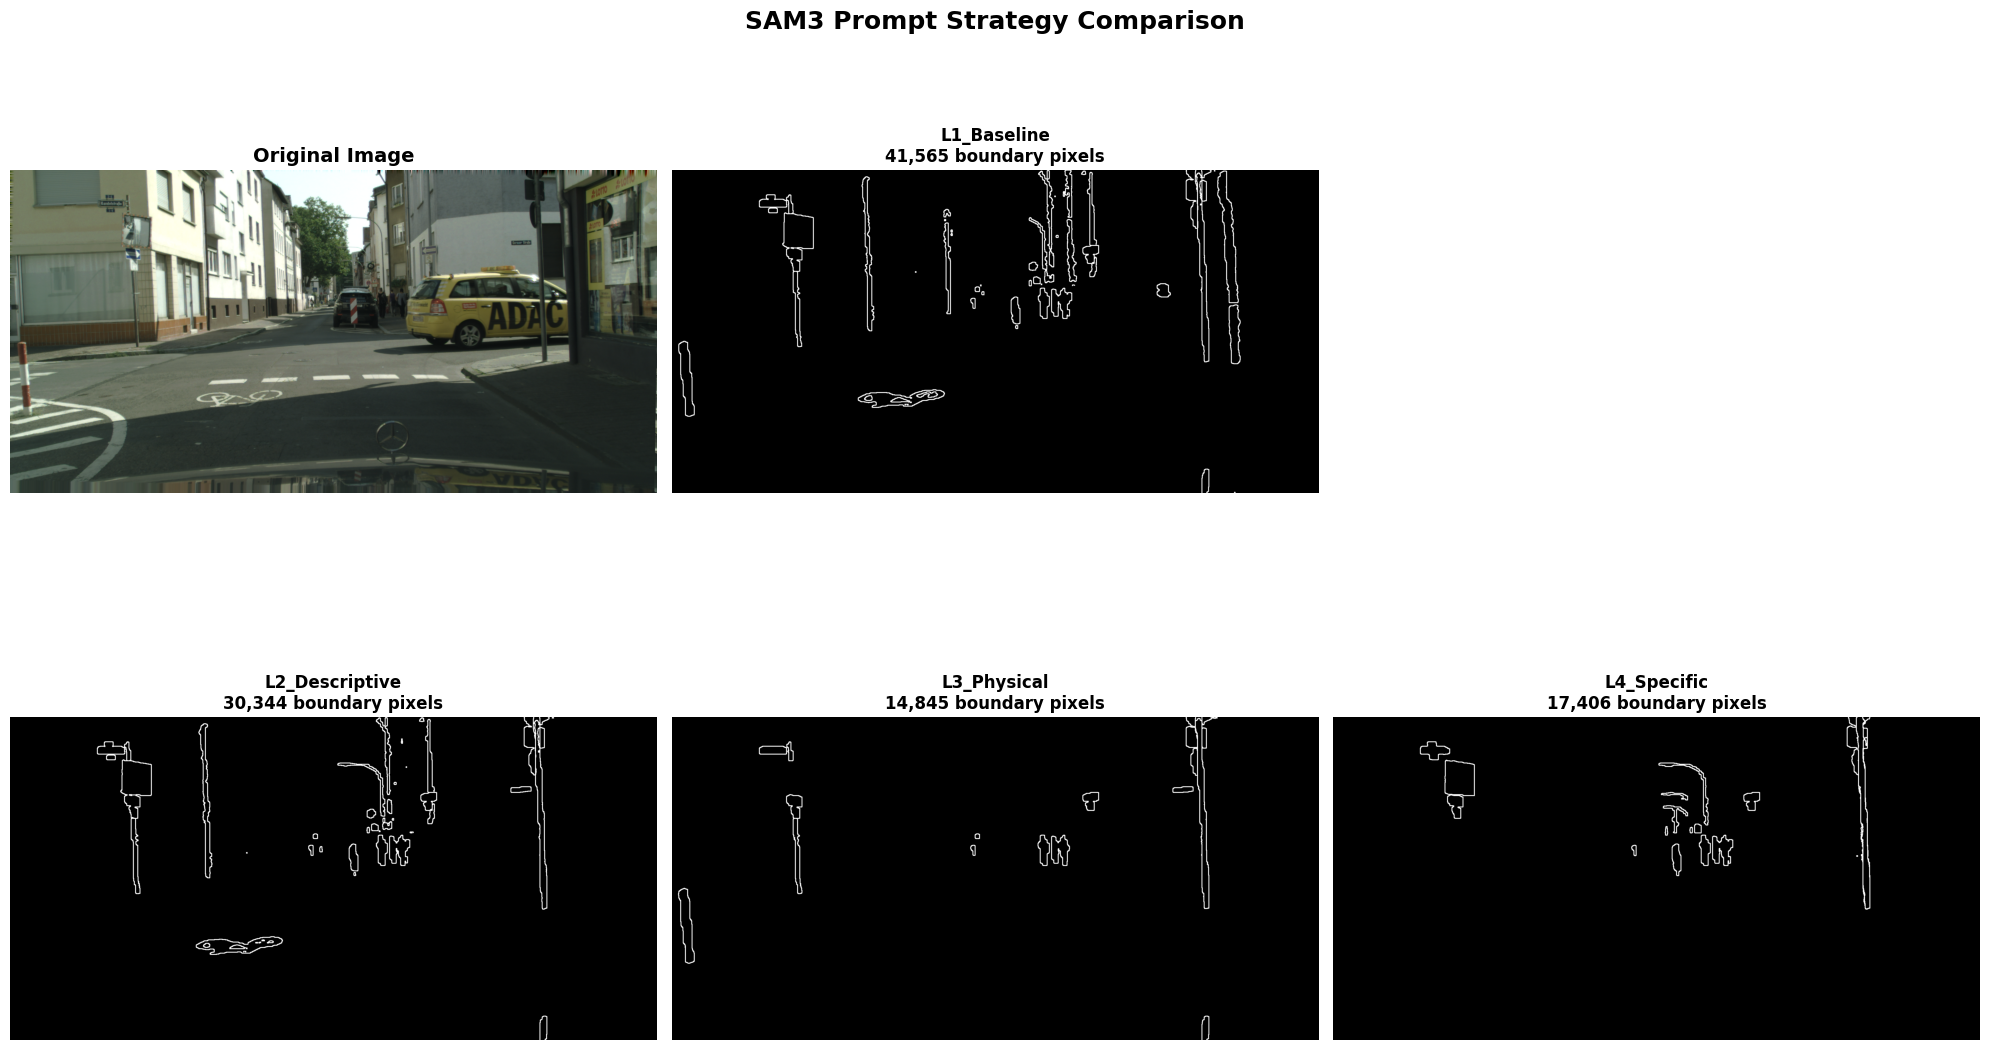

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Original image
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Remove empty subplot
axes[0, 2].axis('off')

# Strategy results
strategy_names = ["L1_Baseline", "L2_Descriptive", "L3_Physical", "L4_Specific"]
positions = [(0, 1), (1, 0), (1, 1), (1, 2)]

for strategy_name, (row, col) in zip(strategy_names, positions):
    boundary = boundaries[strategy_name]
    axes[row, col].imshow(boundary, cmap='gray')
    axes[row, col].set_title(
        f"{strategy_name}\n{boundary.sum():,} boundary pixels", 
        fontsize=12, fontweight='bold'
    )
    axes[row, col].axis('off')

plt.suptitle("SAM3 Prompt Strategy Comparison", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Overlay Comparison

Overlay boundaries on the original image (green) to see detection quality.

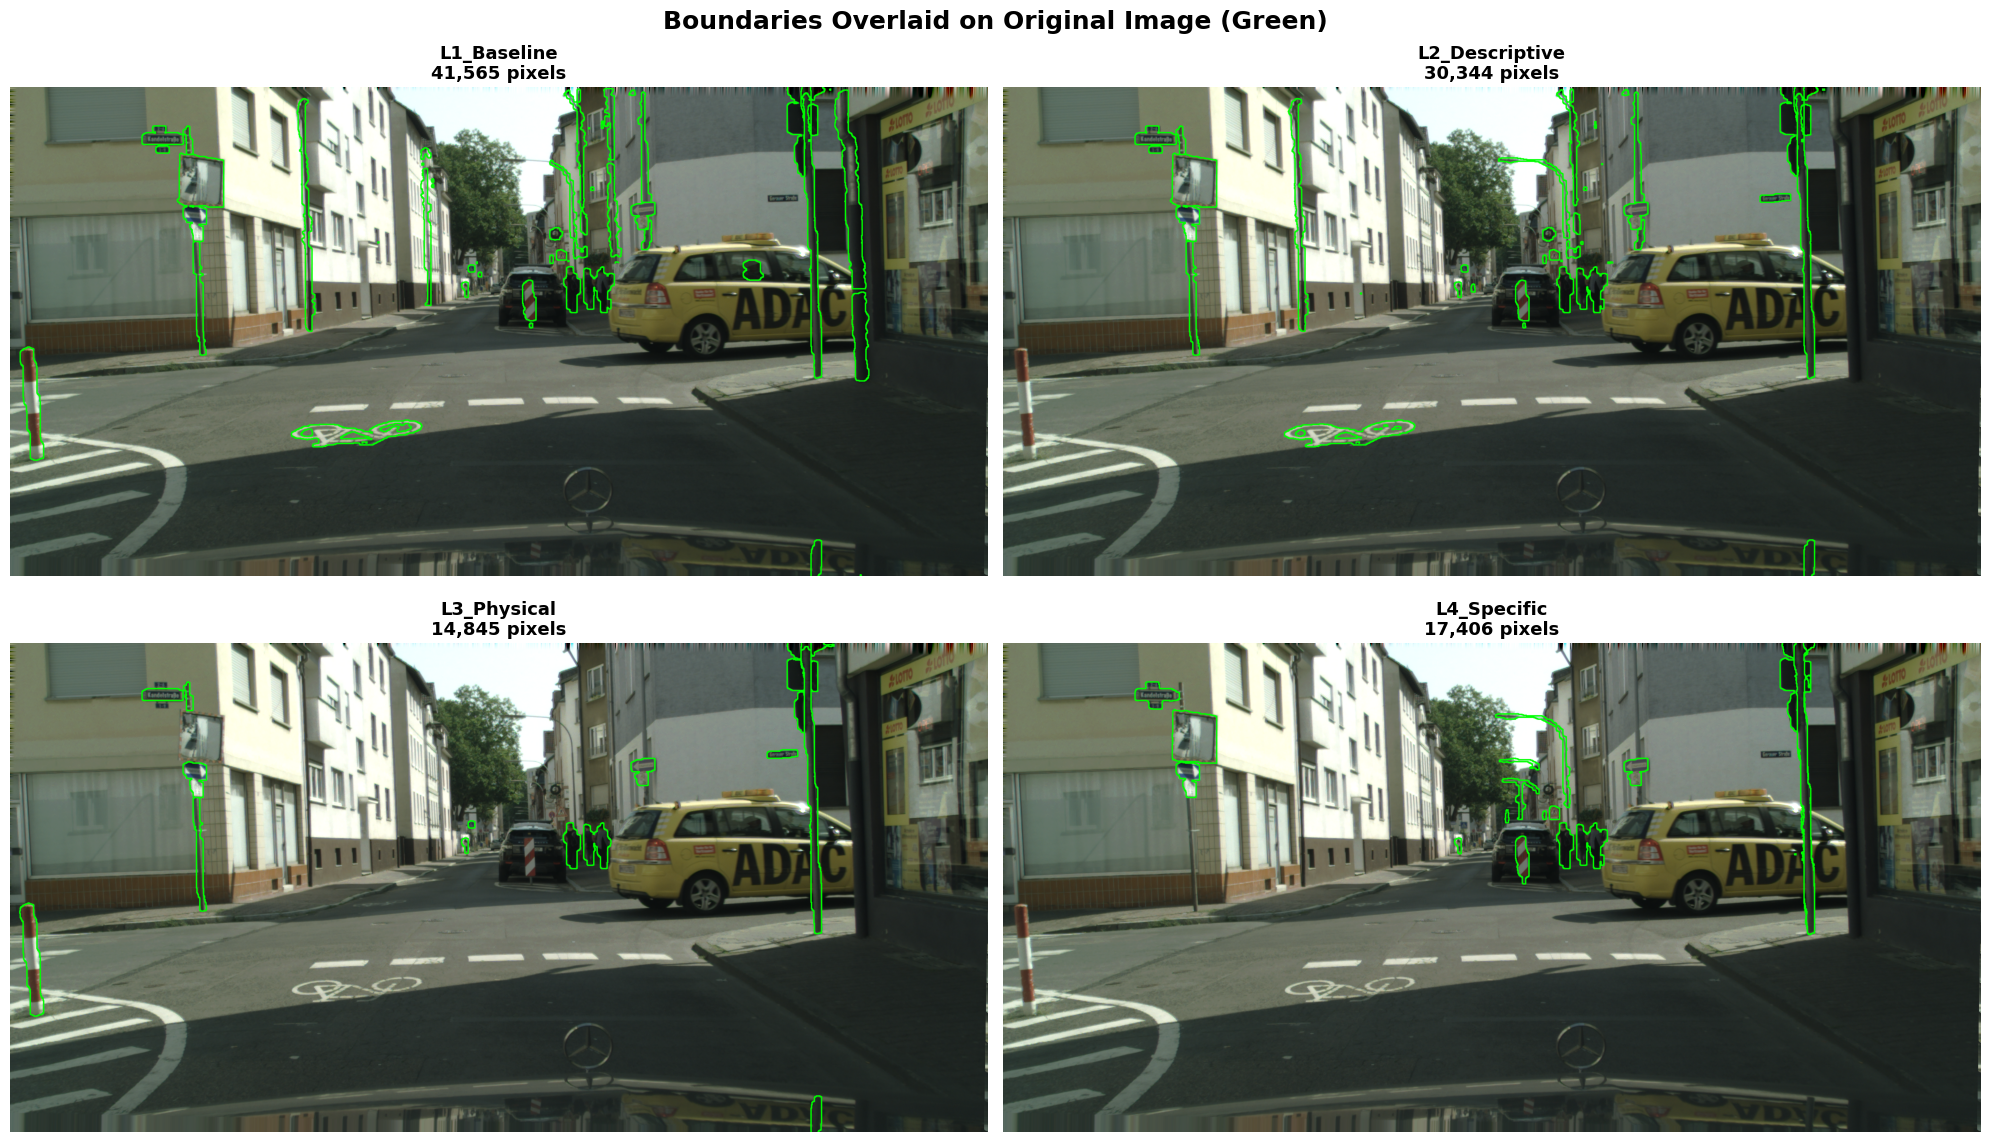

In [8]:
def overlay_boundary(image, boundary, color=(0, 255, 0)):
    """Overlay boundary on image in specified color"""
    img_array = np.array(image).copy()
    img_array[boundary] = color
    return img_array

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for idx, strategy_name in enumerate(["L1_Baseline", "L2_Descriptive", "L3_Physical", "L4_Specific"]):
    row = idx // 2
    col = idx % 2
    
    boundary = boundaries[strategy_name]
    overlay = overlay_boundary(image, boundary)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(
        f"{strategy_name}\n{boundary.sum():,} pixels",
        fontsize=13, fontweight='bold'
    )
    axes[row, col].axis('off')

plt.suptitle("Boundaries Overlaid on Original Image (Green)", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## Difference Analysis

Compare what each strategy detects compared to the baseline (L1).

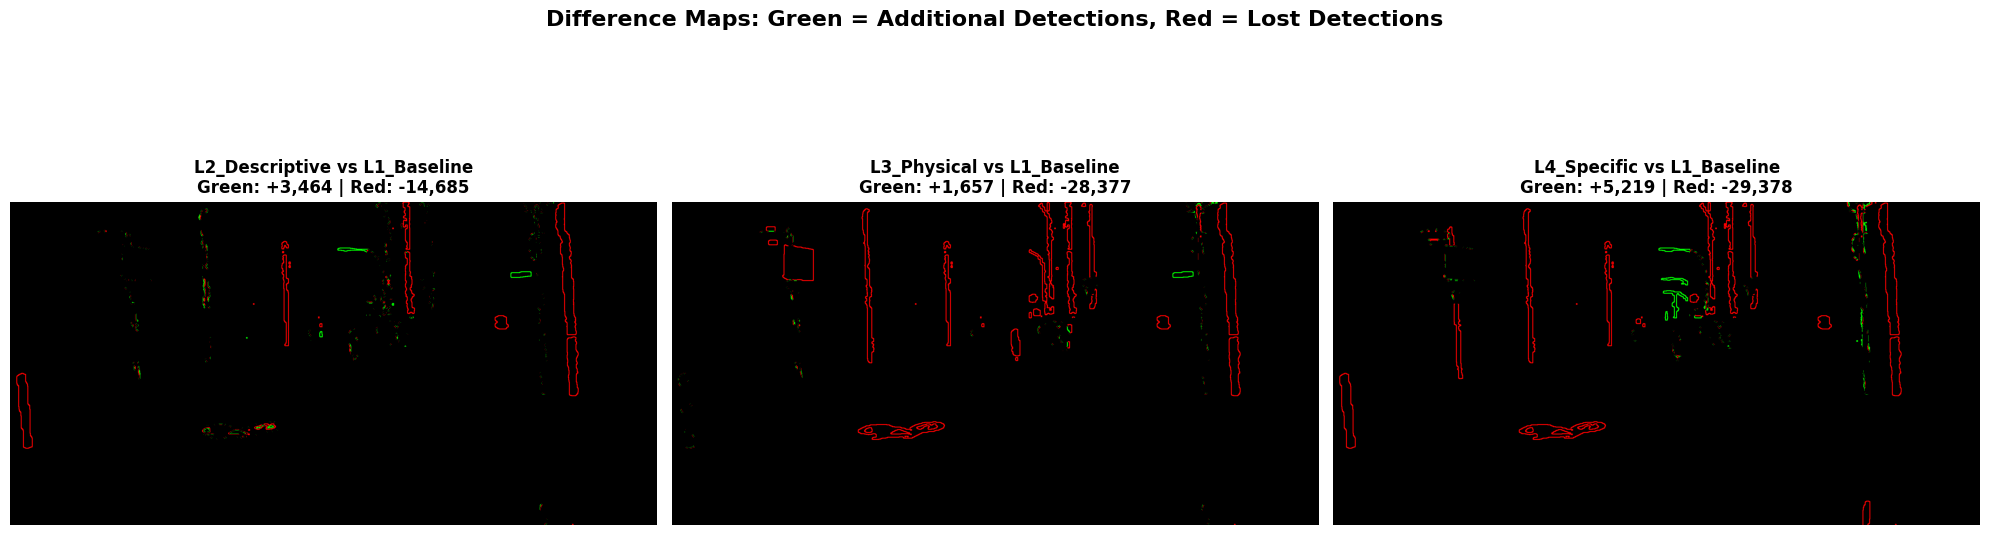

In [9]:
baseline = boundaries["L1_Baseline"]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# L2 vs L1
l2_diff = boundaries["L2_Descriptive"] & ~baseline
l2_lost = baseline & ~boundaries["L2_Descriptive"]
l2_combined = np.zeros((*baseline.shape, 3), dtype=np.uint8)
l2_combined[l2_diff] = [0, 255, 0]  # Green = gained
l2_combined[l2_lost] = [255, 0, 0]   # Red = lost

axes[0].imshow(l2_combined)
axes[0].set_title(
    f"L2_Descriptive vs L1_Baseline\nGreen: +{l2_diff.sum():,} | Red: -{l2_lost.sum():,}",
    fontsize=12, fontweight='bold'
)
axes[0].axis('off')

# L3 vs L1
l3_diff = boundaries["L3_Physical"] & ~baseline
l3_lost = baseline & ~boundaries["L3_Physical"]
l3_combined = np.zeros((*baseline.shape, 3), dtype=np.uint8)
l3_combined[l3_diff] = [0, 255, 0]
l3_combined[l3_lost] = [255, 0, 0]

axes[1].imshow(l3_combined)
axes[1].set_title(
    f"L3_Physical vs L1_Baseline\nGreen: +{l3_diff.sum():,} | Red: -{l3_lost.sum():,}",
    fontsize=12, fontweight='bold'
)
axes[1].axis('off')

# L4 vs L1
l4_diff = boundaries["L4_Specific"] & ~baseline
l4_lost = baseline & ~boundaries["L4_Specific"]
l4_combined = np.zeros((*baseline.shape, 3), dtype=np.uint8)
l4_combined[l4_diff] = [0, 255, 0]
l4_combined[l4_lost] = [255, 0, 0]

axes[2].imshow(l4_combined)
axes[2].set_title(
    f"L4_Specific vs L1_Baseline\nGreen: +{l4_diff.sum():,} | Red: -{l4_lost.sum():,}",
    fontsize=12, fontweight='bold'
)
axes[2].axis('off')

plt.suptitle("Difference Maps: Green = Additional Detections, Red = Lost Detections", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Pairwise Comparisons

Compare consecutive prompt levels to see incremental changes.

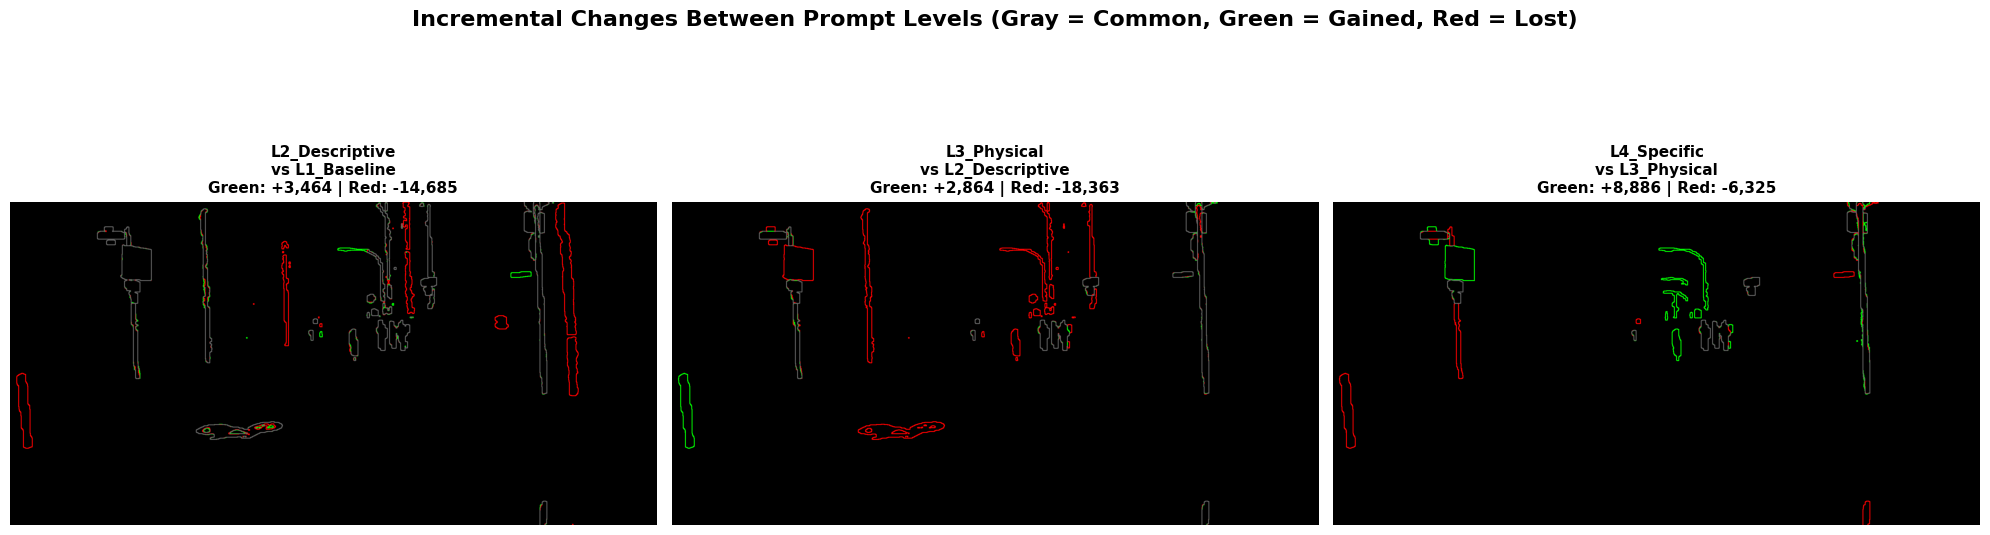

In [10]:
pairs = [
    ("L1_Baseline", "L2_Descriptive"),
    ("L2_Descriptive", "L3_Physical"),
    ("L3_Physical", "L4_Specific")
]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, (strat1, strat2) in enumerate(pairs):
    b1 = boundaries[strat1]
    b2 = boundaries[strat2]
    
    gained = b2 & ~b1
    lost = b1 & ~b2
    
    combined = np.zeros((*b1.shape, 3), dtype=np.uint8)
    combined[gained] = [0, 255, 0]  # Green = gained
    combined[lost] = [255, 0, 0]    # Red = lost
    combined[b1 & b2] = [100, 100, 100]  # Gray = common
    
    axes[idx].imshow(combined)
    axes[idx].set_title(
        f"{strat2}\nvs {strat1}\nGreen: +{gained.sum():,} | Red: -{lost.sum():,}",
        fontsize=11, fontweight='bold'
    )
    axes[idx].axis('off')

plt.suptitle("Incremental Changes Between Prompt Levels (Gray = Common, Green = Gained, Red = Lost)", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Zoomed Region Analysis

Let's zoom into a specific region to see fine-grained differences.

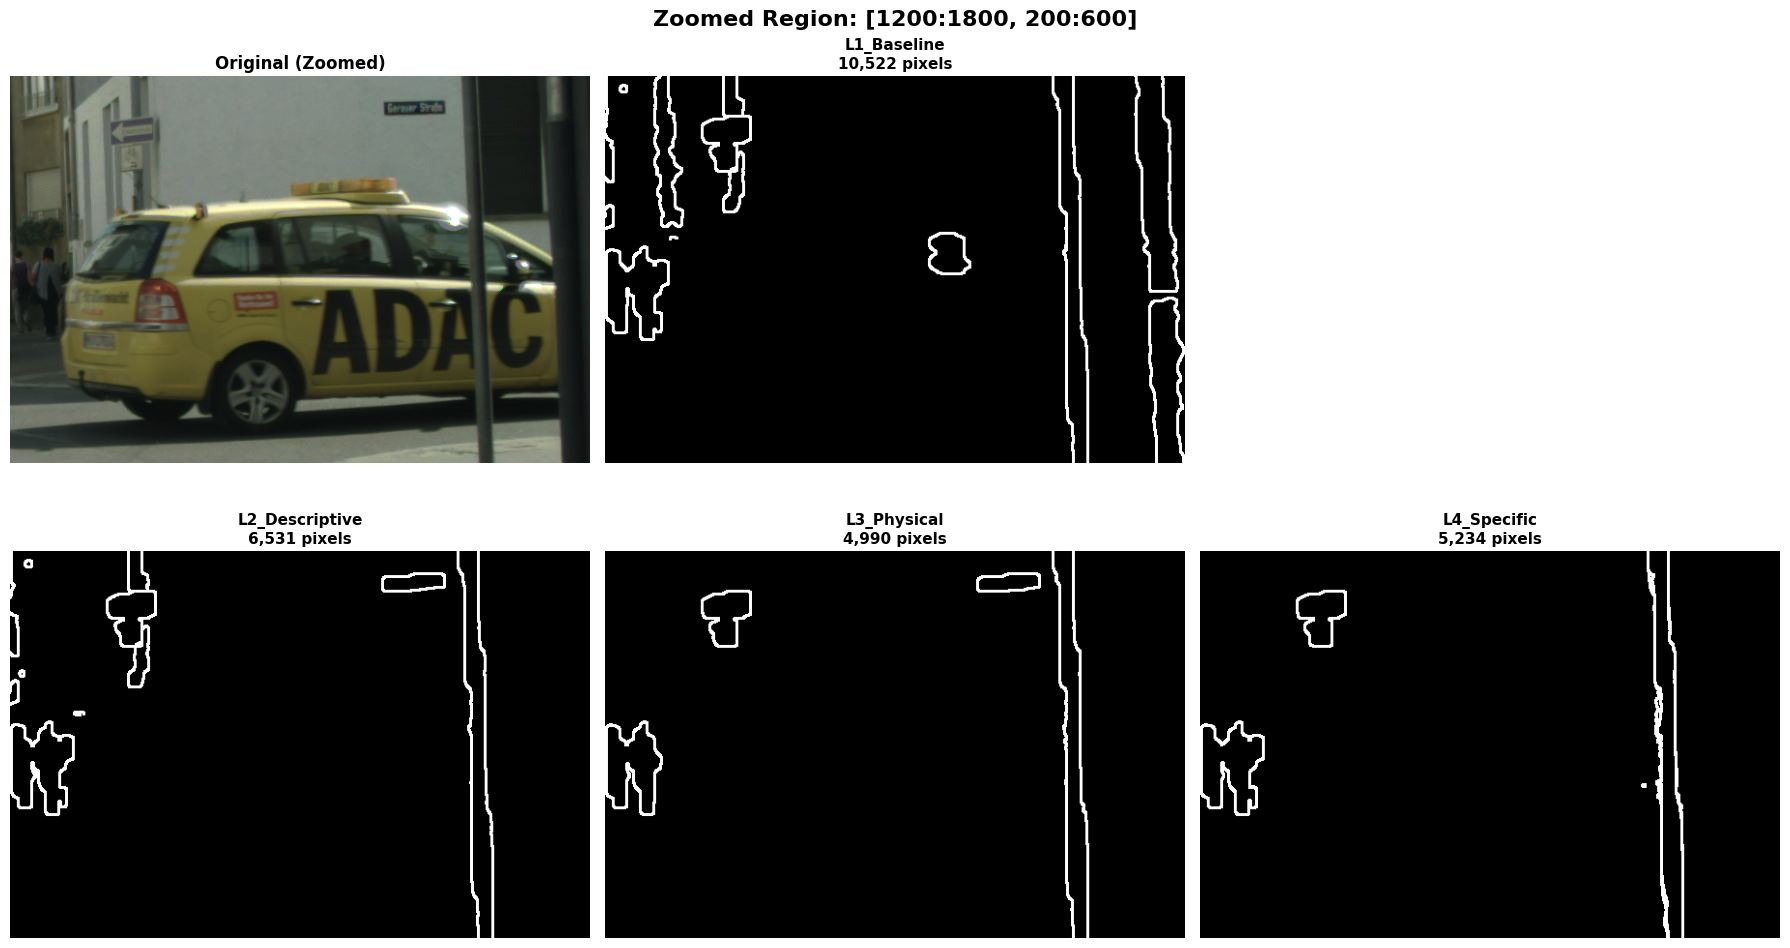

In [11]:
# Define zoom region (adjust based on your image - look for areas with thin objects)
zoom_x1, zoom_x2 = 1200, 1800
zoom_y1, zoom_y2 = 200, 600

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original zoomed
img_zoomed = np.array(image)[zoom_y1:zoom_y2, zoom_x1:zoom_x2]
axes[0, 0].imshow(img_zoomed)
axes[0, 0].set_title("Original (Zoomed)", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Remove one subplot for symmetry
axes[0, 2].axis('off')

# Strategy zooms
positions = [(0, 1), (1, 0), (1, 1), (1, 2)]
for strategy_name, (row, col) in zip(strategy_names, positions):
    boundary_zoomed = boundaries[strategy_name][zoom_y1:zoom_y2, zoom_x1:zoom_x2]
    axes[row, col].imshow(boundary_zoomed, cmap='gray')
    axes[row, col].set_title(
        f"{strategy_name}\n{boundary_zoomed.sum():,} pixels",
        fontsize=11, fontweight='bold'
    )
    axes[row, col].axis('off')

plt.suptitle(f"Zoomed Region: [{zoom_x1}:{zoom_x2}, {zoom_y1}:{zoom_y2}]", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Per-Class Breakdown

Analyze which prompt strategy works best for each object class.

In [12]:
print("="*80)
print("PER-CLASS ANALYSIS")
print("="*80)
print("\nGenerating masks for each class individually...\n")

# Test each class separately
class_results = {}

for train_id, class_name in CLASS_NAMES.items():
    print(f"Testing class {train_id}: {class_name}")
    class_results[train_id] = {}
    
    for strategy_name, full_prompts in PROMPT_STRATEGIES.items():
        # Create single-class prompt dict
        single_prompt = {train_id: full_prompts[train_id]}
        
        # Generate boundary for just this class
        boundary = generate_boundary_for_crop(image, model, processor, DEVICE, prompts=single_prompt)
        class_results[train_id][strategy_name] = boundary.sum()
    
    print(f"  L1: {class_results[train_id]['L1_Baseline']:>6,} | "
          f"L2: {class_results[train_id]['L2_Descriptive']:>6,} | "
          f"L3: {class_results[train_id]['L3_Physical']:>6,} | "
          f"L4: {class_results[train_id]['L4_Specific']:>6,} pixels")

print("\n" + "="*80)

PER-CLASS ANALYSIS

Generating masks for each class individually...

Testing class 4: fence
  L1:      0 | L2:      0 | L3:      0 | L4:      0 pixels
Testing class 5: pole
  L1: 28,126 | L2: 17,324 | L3:  8,203 | L4:  8,372 pixels
Testing class 6: traffic light
  L1:  2,314 | L2:  2,317 | L3:  2,325 | L4:  4,457 pixels
Testing class 7: traffic sign
  L1:  5,390 | L2:  5,746 | L3:  2,772 | L4:  4,732 pixels
Testing class 11: person
  L1:  2,942 | L2:  2,596 | L3:  2,304 | L4:  2,462 pixels
Testing class 12: rider
  L1:      0 | L2:      0 | L3:      0 | L4:      0 pixels
Testing class 17: motorcycle
  L1:      0 | L2:      0 | L3:      0 | L4:      0 pixels
Testing class 18: bicycle
  L1:  3,415 | L2:  2,970 | L3:      0 | L4:      0 pixels



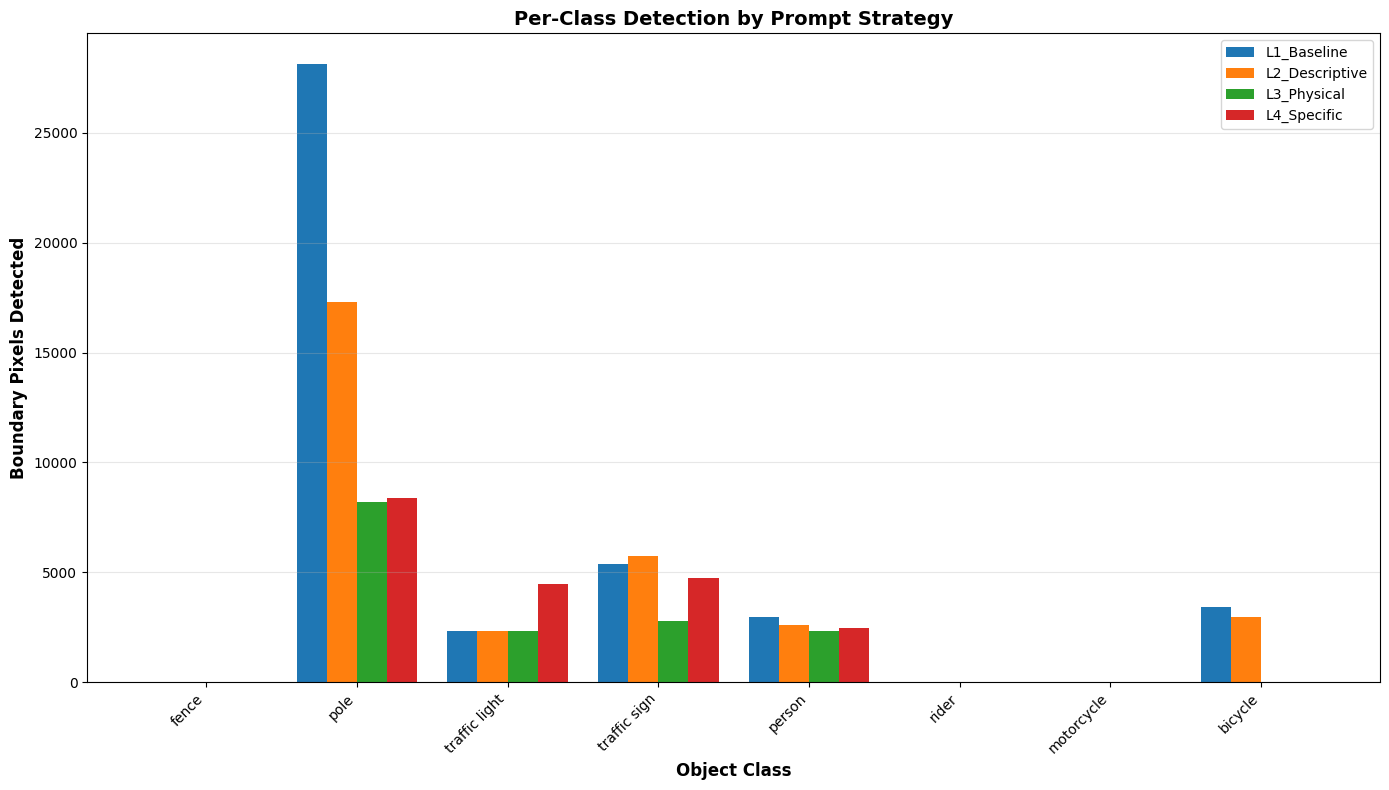

In [13]:
# Visualize per-class results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))

strategies = ["L1_Baseline", "L2_Descriptive", "L3_Physical", "L4_Specific"]
class_ids = sorted(CLASS_NAMES.keys())

x = np.arange(len(class_ids))
width = 0.2

for idx, strategy in enumerate(strategies):
    values = [class_results[cid][strategy] for cid in class_ids]
    ax.bar(x + idx*width, values, width, label=strategy)

ax.set_xlabel('Object Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Boundary Pixels Detected', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Detection by Prompt Strategy', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([CLASS_NAMES[cid] for cid in class_ids], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [14]:
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Image: {SAMPLE_IMAGE.name}")
print(f"Image size: {image.size[0]} x {image.size[1]} pixels")
print("-"*80)

for strategy_name in ["L1_Baseline", "L2_Descriptive", "L3_Physical", "L4_Specific"]:
    total = boundaries[strategy_name].sum()
    vs_baseline = total - boundaries["L1_Baseline"].sum()
    pct_change = 100 * vs_baseline / max(boundaries["L1_Baseline"].sum(), 1)
    
    print(f"{strategy_name:16s}: {total:>8,} pixels", end="")
    if strategy_name != "L1_Baseline":
        sign = "+" if vs_baseline >= 0 else ""
        print(f"  ({sign}{vs_baseline:>6,}, {sign}{pct_change:>5.1f}%)", end="")
    print()

print("="*80)

# Find best strategy overall
best_strategy = max(boundaries.keys(), key=lambda k: boundaries[k].sum())
worst_strategy = min(boundaries.keys(), key=lambda k: boundaries[k].sum())

print(f"\n📊 Most detections: {best_strategy} with {boundaries[best_strategy].sum():,} pixels")
print(f"📊 Fewest detections: {worst_strategy} with {boundaries[worst_strategy].sum():,} pixels")

# Check per-class winners
print("\n📊 Per-class best strategies:")
for train_id, class_name in CLASS_NAMES.items():
    best = max(strategies, key=lambda s: class_results[train_id][s])
    worst = min(strategies, key=lambda s: class_results[train_id][s])
    print(f"  {class_name:14s}: Best={best:16s} ({class_results[train_id][best]:>5,} px), "
          f"Worst={worst:16s} ({class_results[train_id][worst]:>5,} px)")

print("="*80)


SUMMARY STATISTICS
Image: frankfurt_000000_000294_leftImg8bit.png
Image size: 2048 x 1024 pixels
--------------------------------------------------------------------------------
L1_Baseline     :   41,565 pixels
L2_Descriptive  :   30,344 pixels  (-11,221, -27.0%)
L3_Physical     :   14,845 pixels  (-26,720, -64.3%)
L4_Specific     :   17,406 pixels  (-24,159, -58.1%)

📊 Most detections: L1_Baseline with 41,565 pixels
📊 Fewest detections: L3_Physical with 14,845 pixels

📊 Per-class best strategies:
  fence         : Best=L1_Baseline      (    0 px), Worst=L1_Baseline      (    0 px)
  pole          : Best=L1_Baseline      (28,126 px), Worst=L3_Physical      (8,203 px)
  traffic light : Best=L4_Specific      (4,457 px), Worst=L1_Baseline      (2,314 px)
  traffic sign  : Best=L2_Descriptive   (5,746 px), Worst=L3_Physical      (2,772 px)
  person        : Best=L1_Baseline      (2,942 px), Worst=L3_Physical      (2,304 px)
  rider         : Best=L1_Baseline      (    0 px), Worst=L1_Bas

## Recommendations

Based on the analysis above:

### When to use each prompt strategy:

- **L1_Baseline**: Use when you want simple, fast, generic detection. Good baseline for comparison.

- **L2_Descriptive**: Use when you need slightly better specificity without making prompts too long.

- **L3_Physical**: Use when physical attributes are important (shape, size, vertical/horizontal orientation).

- **L4_Specific**: Use when context matters (street, road, mounted, etc.). May be too specific and miss edge cases.

### Observations:

1. **More specific ≠ always better**: Sometimes generic prompts work better because they're less constraining
2. **Class-dependent**: Different classes benefit from different prompt strategies
3. **Context matters**: Urban scene-specific terms (street, road, traffic) can help or hurt depending on the situation

### Next Steps:

1. Test on multiple images to see if results generalize
2. Consider a **hybrid strategy**: Use different prompt levels for different classes
3. Run full dataset generation with your chosen strategy
4. Measure downstream task performance (segmentation mIoU) to determine true effectiveness

### Running Full Dataset Generation:

```bash
# Use your chosen strategy (e.g., L2_Descriptive)
python generate_sam3_masks.py \\
    --data_root ../data/cityscapes \\
    --strategy baseline \\
    --prompt_level L2_Descriptive
```

*Note: You'll need to add prompt_level support to the generation script to use different prompts.*